In [24]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import os
from os import walk
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from datetime import datetime,timedelta
import talib as ta
from sklearn.preprocessing import MinMaxScaler
from math import floor
import sys
import pandas as pd
from tqdm import tqdm
import shutil

In [4]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [88]:
companies = []
data_path = "Best/Graphs"
for (dirpath, dirnames, filenames) in walk(data_path):
    companies.extend(filenames)
    break 
print(len(companies))

49


In [ ]:
def company(stock,startDate, endDate,startingCapital = (500_000/len(companies)),plot = False, s = 1):
    model = "Best/Models/{}-model.json".format(stock)
    if not os.path.isfile("{}/saved_model.pb".format(model)):
        return 0,0,0,0,0
    start = startDate
    
    dataPath = "/Users/ishan/Coding/Wpi/StockMarketSimulationIQP/Datasets/30y_stock_csvs"
    dataTrain = pd.read_csv("{}/{}.csv".format(dataPath,stock)) #import csv
    dataTrain['Datetime']= pd.to_datetime(dataTrain['Datetime'])
    if startDate < dataTrain.iloc[0, :]['Datetime']:
        startDate = dataTrain.iloc[0, :]['Datetime']
    days = timedelta(93)
    startDate = startDate - days
    if startDate < dataTrain.iloc[0,:]['Datetime']:
        startDate = dataTrain.iloc[0,:]['Datetime']

    dataTrain = dataTrain[~(dataTrain['Datetime'] < startDate)]
    dataTrain = dataTrain[~(dataTrain['Datetime'] > endDate)]
    rsiPeriod = 14
    adxPeriod = 14
    shift = 1
    leftshift = 33
    window = 60

    # %%
    variablesToInclude = ['Close','Volume',"RSI","ADX","fastd","fastk","macd"]
    numberOfFeatures = len(variablesToInclude)
    
    trainingDataPoints = round(len(dataTrain) * .4)
    
    dataTrain.rename(columns = {'CLOSE':'Close'}, inplace = True)
    dataTrain.rename(columns = {'HIGH':'High'}, inplace = True)
    dataTrain.rename(columns = {'LOW':'Low'}, inplace = True)
    dataTrain.rename(columns = {'VOLUME':'Volume'}, inplace = True)


    # %%

    dataTrain['Close'] = dataTrain['Close'].astype(float).fillna(0)
    data = dataTrain['Close']
    if len(dataTrain) == 0:
        return 0,0,0,0,0
    dataTrain["RSI"] = ta.RSI(dataTrain['Close'],rsiPeriod).fillna(0)
    dataTrain["ADX"] = ta.ADX(dataTrain['High'],dataTrain['Low'],dataTrain['Close'],adxPeriod).fillna(0)
    fastk, fastd = ta.STOCHF(dataTrain['High'],dataTrain['Low'],dataTrain['Close'])
    dataTrain['fastd'] = fastd
    dataTrain['fastk'] = fastk
    macd, macdsignal, macdhist = ta.MACD(dataTrain['Close'])
    dataTrain['macd'] = macd
    dataTrain['macdsignal'] = macdsignal
    dataTrain['macdhist'] = macdhist
    upper,middle,lower = ta.BBANDS(dataTrain['Close'])
    dataTrain['bb_lowerband'] = lower
    dataTrain['bb_middleband'] = middle
    dataTrain['bb_upperband'] = upper

    # %%
    newTrain = pd.DataFrame()
    newTrain = dataTrain[variablesToInclude]
    newTrain["Close"] = newTrain['Close'].shift(1)

    # %%

    trainingSet = newTrain.iloc[:,0:numberOfFeatures].values #convert to numpy to train RNN
    ySet = data.astype(float).values.reshape(-1, 1)

    # %% [markdown]
    # ## Feature Scaling

    # %%
    # Use normalization x - min(x) / max(min) - min(x)
    sc = MinMaxScaler(feature_range=(0,1)) # all values between 0 and 1
    ySC = MinMaxScaler(feature_range=(0,1))
    ySCSet = ySC.fit_transform(ySet)
    scaleTrainingSet = sc.fit_transform(trainingSet)


    
    regressor=tf.keras.models.load_model(model)
    dataTest = pd.read_csv("{}/{}.csv".format(dataPath,stock)) #import csv
    dataTest.rename(columns = {'CLOSE':'Close'}, inplace = True)
    dataTest.rename(columns = {'HIGH':'High'}, inplace = True)
    dataTest.rename(columns = {'LOW':'Low'}, inplace = True)
    dataTest.rename(columns = {'VOLUME':'Volume'}, inplace = True)

    # %%
    dataTest['Datetime']= pd.to_datetime(dataTest['Datetime'])
    if startDate < dataTrain.iloc[0,:]['Datetime']:
        startDate = dataTrain.iloc[0,:]['Datetime']
    dataTest = dataTest[~(dataTest['Datetime'] < startDate)]
    dataTest = dataTest[~(dataTest['Datetime'] > endDate)]
    dataTest['Close'] = dataTest['Close'].astype(float)
    dataTest["RSI"] = ta.RSI(dataTest['Close'],rsiPeriod)
    dataTest["ADX"] = ta.ADX(dataTest['High'],dataTest['Low'],dataTest['Close'],adxPeriod)
    fastk, fastd = ta.STOCHF(dataTest['High'],dataTest['Low'],dataTest['Close'])
    dataTest['fastd'] = fastd
    dataTest['fastk'] = fastk
    macd, macdsignal, macdhist = ta.MACD(dataTest['Close'])
    dataTest['macd'] = macd
    dataTest['macdsignal'] = macdsignal
    dataTest['macdhist'] = macdhist
    upper,middle,lower = ta.BBANDS(dataTest['Close'])
    dataTest['bb_lowerband'] = lower
    dataTest['bb_middleband'] = middle
    dataTest['bb_upperband'] = upper
    dataTest['Daily Returns'] = dataTest['Close'].pct_change(1)
    
    Sharpe_Ratio = dataTest['Daily Returns'].mean() / dataTest['Daily Returns'].std()
    tradingdays = (endDate-start).days
    sharperatio = (tradingdays ** 0.5) * Sharpe_Ratio
    negs = dataTest[dataTest['Daily Returns']<0]['Daily Returns']
    sortinoRatio = (dataTest['Daily Returns'].mean() / negs.std()) * (tradingdays ** 0.5)

    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    Roll_Max = dataTest['Daily Returns'].cummax()
    Daily_Drawdown = (dataTest['Daily Returns']/Roll_Max) - 1.0

    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    calm = dataTest['Daily Returns'].mean()
    calmerRatio = (calm/Max_Daily_Drawdown) * (tradingdays ** 0.5)
    
    # %%
    newTest = pd.DataFrame()
    newTest = dataTest[variablesToInclude]
    
    # %%
    realStockPrice = dataTest['Close'].values #convert to numpy to train RNN
    newTest["Close"] = newTest['Close'].shift(1)
    trainingSet = newTest.iloc[:,0:numberOfFeatures].values #convert to numpy to train RNN

    inputs = trainingSet
    inputs = sc.transform(inputs)

    # %%
    xTest = []
    for i in range(window+leftshift, len(inputs)):
        xTest.append(inputs[i-window:i])
    xTest = np.array(xTest)
    # batchsize, inputSize, numberOfFeatures
    xTest = np.reshape(
        xTest, (xTest.shape[0], xTest.shape[1], numberOfFeatures))

    # %%
    predictedPrice = regressor.predict(xTest)
    predictedPrice = ySC.inverse_transform(predictedPrice)
    stocksOwned = {}
    startingValue = startingCapital
    liquidValue = startingValue
    dailyReturns = []
    sold = 0
    diffrence = (len(realStockPrice)) - (len(predictedPrice))

    #realStockPrice = realStockPrice[diffrence-s:]

    # %% [markdown]
    # ## Predict price

    # %%



    loss = pd.DataFrame(columns=['i', 'Price'])
    profit = pd.DataFrame(columns=['i', 'Price'])
    buy = pd.DataFrame(columns=['i', 'Price'])

    for i in range(len(predictedPrice)):
        if realStockPrice[i] < predictedPrice[i] and 'GOOGL' not in stocksOwned:
            stocksOwned['GOOGL'] = (realStockPrice[i], liquidValue/realStockPrice[i])
            liquidValue -= liquidValue/realStockPrice[i] * realStockPrice[i]
            buy.loc[len(buy)] = [i, realStockPrice[i]]
        elif 'GOOGL' in stocksOwned and stocksOwned['GOOGL'][0] < realStockPrice[i]:
            if stocksOwned['GOOGL'][1] * realStockPrice[i] > stocksOwned['GOOGL'][1] * stocksOwned['GOOGL'][0]:
                profit.loc[len(profit)] = [i, realStockPrice[i]]
            else:
                loss.loc[len(loss)] = [i, realStockPrice[i]]
            liquidValue += stocksOwned['GOOGL'][1] * realStockPrice[i]
            percentGain = (realStockPrice[i] - stocksOwned['GOOGL'][0]) / stocksOwned['GOOGL'][0]
            sold += 1
            dailyReturns.append(percentGain)
            stocksOwned.pop('GOOGL')
        if 'GOOGL' in stocksOwned and i == len(predictedPrice) - 1:
            if stocksOwned['GOOGL'][1] * realStockPrice[i] > stocksOwned['GOOGL'][1] * stocksOwned['GOOGL'][0]:
                profit.loc[len(profit)] = [i, realStockPrice[i]]
            else:
                loss.loc[len(loss)] = [i, realStockPrice[i]]
            liquidValue += stocksOwned['GOOGL'][1] * realStockPrice[i]
            percentGain = (realStockPrice[i] - stocksOwned['GOOGL'][0]) / stocksOwned['GOOGL'][0]
            dailyReturns.append(percentGain)
            stocksOwned.pop('GOOGL')
            sold += 1
    if plot:
        plt.plot(realStockPrice, color='red', label="Real Stock Price")
        plt.plot(predictedPrice, color='blue', label="Predicted Stock Price")
        plt.scatter(buy['i'], buy['Price'], marker="o", label = 'Buy', s=50)
        plt.scatter(profit['i'], profit['Price'], marker="^",
                    color='green', label="Sell - Profit", s=50)
        plt.scatter(loss['i'], loss['Price'], marker="v",
                    color='red', label='Sell - Loss ', s=50)
        plt.title("{} Stock Price".format(stock))
        plt.xlabel('Time')
        plt.ylabel("Price")
        plt.legend()
        plt.savefig('graphs/{}.png'.format(stock))
        plt.figure()

    dailyReturns = pd.Series(dailyReturns,dtype='float')
    if dailyReturns and dailyReturns.std():
        Sharpe_Ratio = dailyReturns.mean() / dailyReturns.std()
        tradingdays = (endDate-start).days
        sharperatio = (tradingdays ** 0.5) * Sharpe_Ratio
    else:
        Sharpe_Ratio = 0
    negs = dailyReturns[dailyReturns<0]
    if negs and negs.std():
        sortinoRatio = (dailyReturns.mean() / negs.std()) * (tradingdays ** 0.5)

    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    Roll_Max = dailyReturns.cummax()
    Daily_Drawdown = (dailyReturns/Roll_Max) - 1.0

    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    calm = dailyReturns.mean()
    calmerRatio = (calm/Max_Daily_Drawdown) * (tradingdays ** 0.5)
    calmerRatio = 0
    

    profit = (liquidValue - startingValue)
    return profit,sharperatio,sortinoRatio,calmerRatio,sold


In [90]:
def optimize(stock,startDate, endDate,startingCapital = (500_000/505),plot = False):
    model = "Best/Models/{}-model.json".format(stock)
    if not os.path.isfile("{}/saved_model.pb".format(model)):
        return 0,0,0,0,0
    start = startDate
    days = timedelta(93)
    startDate = startDate - days
    dataPath = "/Users/ishan/Coding/Wpi/StockMarketSimulationIQP/Datasets/30y_stock_csvs"
    dataTrain = pd.read_csv("{}/{}.csv".format(dataPath,stock)) #import csv
    dataTrain['Datetime']= pd.to_datetime(dataTrain['Datetime'])
    if startDate < dataTrain.iloc[0,:]['Datetime']:
        startDate = dataTrain.iloc[0,:]['Datetime']

    dataTrain = dataTrain[~(dataTrain['Datetime'] < startDate)]
    dataTrain = dataTrain[~(dataTrain['Datetime'] > endDate)]
    rsiPeriod = 14
    adxPeriod = 14
    shift = 1
    leftshift = 33
    window = 60

    # %%
    variablesToInclude = ['Close','Volume',"RSI","ADX","fastd","fastk","macd"]
    numberOfFeatures = len(variablesToInclude)
    
    trainingDataPoints = round(len(dataTrain) * .4)
    
    dataTrain.rename(columns = {'CLOSE':'Close'}, inplace = True)
    dataTrain.rename(columns = {'HIGH':'High'}, inplace = True)
    dataTrain.rename(columns = {'LOW':'Low'}, inplace = True)
    dataTrain.rename(columns = {'VOLUME':'Volume'}, inplace = True)


    # %%

    dataTrain['Close'] = dataTrain['Close'].astype(float).fillna(0)
    data = dataTrain['Close']
    dataTrain["RSI"] = ta.RSI(dataTrain['Close'],rsiPeriod).fillna(0)
    dataTrain["ADX"] = ta.ADX(dataTrain['High'],dataTrain['Low'],dataTrain['Close'],adxPeriod).fillna(0)
    fastk, fastd = ta.STOCHF(dataTrain['High'],dataTrain['Low'],dataTrain['Close'])
    dataTrain['fastd'] = fastd
    dataTrain['fastk'] = fastk
    macd, macdsignal, macdhist = ta.MACD(dataTrain['Close'])
    dataTrain['macd'] = macd
    dataTrain['macdsignal'] = macdsignal
    dataTrain['macdhist'] = macdhist
    upper,middle,lower = ta.BBANDS(dataTrain['Close'])
    dataTrain['bb_lowerband'] = lower
    dataTrain['bb_middleband'] = middle
    dataTrain['bb_upperband'] = upper

    # %%
    newTrain = pd.DataFrame()
    newTrain = dataTrain[variablesToInclude]
    newTrain["Close"] = newTrain['Close'].shift(1)

    # %%

    trainingSet = newTrain.iloc[:,0:numberOfFeatures].values #convert to numpy to train RNN
    ySet = data.astype(float).values.reshape(-1, 1)

    # %% [markdown]
    # ## Feature Scaling

    # %%
    # Use normalization x - min(x) / max(min) - min(x)
    sc = MinMaxScaler(feature_range=(0,1)) # all values between 0 and 1
    ySC = MinMaxScaler(feature_range=(0,1))
    ySCSet = ySC.fit_transform(ySet)
    scaleTrainingSet = sc.fit_transform(trainingSet)


    
    regressor=tf.keras.models.load_model(model)
    dataTest = pd.read_csv("{}/{}.csv".format(dataPath,stock)) #import csv
    dataTest.rename(columns = {'CLOSE':'Close'}, inplace = True)
    dataTest.rename(columns = {'HIGH':'High'}, inplace = True)
    dataTest.rename(columns = {'LOW':'Low'}, inplace = True)
    dataTest.rename(columns = {'VOLUME':'Volume'}, inplace = True)

    # %%
    dataTest['Datetime']= pd.to_datetime(dataTest['Datetime'])
    if startDate < dataTrain.iloc[0,:]['Datetime']:
        startDate = dataTrain.iloc[0,:]['Datetime']
    dataTest = dataTest[~(dataTest['Datetime'] < startDate)]
    dataTest = dataTest[~(dataTest['Datetime'] > endDate)]
    dataTest['Close'] = dataTest['Close'].astype(float)
    dataTest["RSI"] = ta.RSI(dataTest['Close'],rsiPeriod)
    dataTest["ADX"] = ta.ADX(dataTest['High'],dataTest['Low'],dataTest['Close'],adxPeriod)
    fastk, fastd = ta.STOCHF(dataTest['High'],dataTest['Low'],dataTest['Close'])
    dataTest['fastd'] = fastd
    dataTest['fastk'] = fastk
    macd, macdsignal, macdhist = ta.MACD(dataTest['Close'])
    dataTest['macd'] = macd
    dataTest['macdsignal'] = macdsignal
    dataTest['macdhist'] = macdhist
    upper,middle,lower = ta.BBANDS(dataTest['Close'])
    dataTest['bb_lowerband'] = lower
    dataTest['bb_middleband'] = middle
    dataTest['bb_upperband'] = upper
    dataTest['Daily Returns'] = dataTest['Close'].pct_change(1)
    
    Sharpe_Ratio = dataTest['Daily Returns'].mean() / dataTest['Daily Returns'].std()
    tradingdays = (endDate-start).days
    sharperatio = (tradingdays ** 0.5) * Sharpe_Ratio
    negs = dataTest[dataTest['Daily Returns']<0]['Daily Returns']
    sortinoRatio = (dataTest['Daily Returns'].mean() / negs.std()) * (tradingdays ** 0.5)

    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    Roll_Max = dataTest['Daily Returns'].cummax()
    Daily_Drawdown = (dataTest['Daily Returns']/Roll_Max) - 1.0

    # Next we calculate the minimum (negative) daily drawdown in that window.
    # Again, use min_periods=1 if you want to allow the expanding window
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    calm = dataTest['Daily Returns'].mean()
    calmerRatio = (calm/Max_Daily_Drawdown) * (tradingdays ** 0.5)
    
    # %%
    newTest = pd.DataFrame()
    newTest = dataTest[variablesToInclude]
    
    # %%
    realStockPrice = dataTest['Close'].values #convert to numpy to train RNN
    newTest["Close"] = newTest['Close'].shift(1)
    trainingSet = newTest.iloc[:,0:numberOfFeatures].values #convert to numpy to train RNN

    inputs = trainingSet
    inputs = sc.transform(inputs)

    # %%
    xTest = []
    for i in range(window+leftshift, len(inputs)):
        xTest.append(inputs[i-window:i])
    xTest = np.array(xTest)
    # batchsize, inputSize, numberOfFeatures
    xTest = np.reshape(
        xTest, (xTest.shape[0], xTest.shape[1], numberOfFeatures))

    # %%
    predictedPrice = regressor.predict(xTest)
    predictedPrice = ySC.inverse_transform(predictedPrice)
    shift = 0
    maxProfit = float('-inf')
    maxRange = len(realStockPrice) - len(predictedPrice) + 1
    temp = realStockPrice
    
    for shiftTemp in range(min(maxRange,20)):
        realStockPrice = temp
        stocksOwned = {}
        startingValue = startingCapital
        liquidValue = startingValue
        dailyReturns = []
        sold = 0
        realStockPrice = realStockPrice[window+leftshift-shiftTemp:]
       
    # %% [markdown]
    # ## Predict price
        if plot:
            plt.plot(realStockPrice, color='red', label="Real Stock Price")
            plt.plot(predictedPrice, color='blue', label="Predicted Stock Price")
            plt.title("{} Stock Price".format(stock))
            plt.xlabel('Time')
            plt.ylabel("Price")
            plt.legend()
            plt.savefig('graphs/{}.png'.format(stock))
            plt.figure()

        for i in range(len(predictedPrice)):
            if realStockPrice[i] < predictedPrice[i] and 'GOOGL' not in stocksOwned:
                stocksOwned['GOOGL'] = (realStockPrice[i], liquidValue/realStockPrice[i])
                liquidValue -= liquidValue/realStockPrice[i] * realStockPrice[i]
            elif 'GOOGL' in stocksOwned and stocksOwned['GOOGL'][0] < realStockPrice[i]:
                liquidValue += stocksOwned['GOOGL'][1] * realStockPrice[i]
                percentGain = (realStockPrice[i] - stocksOwned['GOOGL'][0]) / stocksOwned['GOOGL'][0]
                sold += 1
                dailyReturns.append(percentGain)
                stocksOwned.pop('GOOGL')
            if 'GOOGL' in stocksOwned and i == len(predictedPrice) - 1:
                liquidValue += stocksOwned['GOOGL'][1] * realStockPrice[i]
                percentGain = (realStockPrice[i] - stocksOwned['GOOGL'][0]) / stocksOwned['GOOGL'][0]
                dailyReturns.append(percentGain)
                stocksOwned.pop('GOOGL')
                sold += 1
        profit = (liquidValue - startingValue)

        if profit > maxProfit:
            maxProfit = profit
            shift = shiftTemp
    
    # dailyReturns = pd.Series(dailyReturns,dtype='float')
    # Sharpe_Ratio = dailyReturns.mean() / dailyReturns.std()
    # tradingdays = (endDate-start).days
    # sharperatio = (tradingdays ** 0.5) * Sharpe_Ratio
    # negs = dailyReturns[dailyReturns<0]
    # sortinoRatio = (dailyReturns.mean() / negs.std()) * (tradingdays ** 0.5)

    # # Calculate the max drawdown in the past window days for each day in the series.
    # # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    # Roll_Max = dailyReturns.cummax()
    # Daily_Drawdown = (dailyReturns/Roll_Max) - 1.0

    # # Next we calculate the minimum (negative) daily drawdown in that window.
    # # Again, use min_periods=1 if you want to allow the expanding window
    # Max_Daily_Drawdown = Daily_Drawdown.cummin()
    # calm = dailyReturns.mean()
    # calmerRatio = (calm/Max_Daily_Drawdown) * (tradingdays ** 0.5)
    

    
    return maxProfit,shift


In [91]:
def eval(startDate="1982-3-12", endDate="2022-02-1",weighted = False, companies = companies, s = 1):
    startDate = datetime.strptime(startDate, "%Y-%m-%d")
    endDate = datetime.strptime(endDate, "%Y-%m-%d")
    startDateThreshold = datetime.strptime("1982-3-12", "%Y-%m-%d")
    spstart = startDate

    if startDateThreshold > startDate:
        spstart = startDateThreshold
    profit = 0

    with HiddenPrints():
        sp500 = yf.download('^GSPC',spstart,endDate)

    profitsp500percentage = ((sp500['Close'][-1] - sp500['Close'][0])/sp500['Close'][0])*100
    profitsp500 = (500_000) * (profitsp500percentage/100)

    profit = 0
    sharperatio = []
    sortinoRatio = []
    calmerRatio = []

    topStock = ""
    maxProfit = float('-inf')
    lowestStock = ""
    minProfit = float('inf')

    index = 0
    sold = 0
    
    for i in tqdm(companies):
        index += 1
       

        if weighted:    
            weightC = weight[i]
            startingCapital = 500_000 * weightC
            profitC, sharperatioC, sortinoRatioC, calmerRatioC,soldC = company(i, startDate, endDate, startingCapital, s = s)

        else:
            i = i[:-4]
            profitC, sharperatioC, sortinoRatioC, calmerRatioC, soldC = company(
                i, startDate, endDate,s = s)

        profit += profitC
        sharperatio.append(sharperatioC)
        sortinoRatio.append(sortinoRatioC)
        calmerRatio.append(calmerRatioC)
        sold += soldC
        if profitC < minProfit:
            minProfit = profitC
            lowestStock = i

        if profitC > maxProfit:
            maxProfit = profitC
            topStock = i
        
    sharperatio = pd.Series(sharperatio).dropna()
    sortinoRatio = pd.Series(sortinoRatio).dropna()
    
    profitPercentage = (profit/((500_000/len(companies))*index))*100
    profit = round(profit,2)
    profitPercentage = round(profitPercentage,2)
    profitsp500 = round(profitsp500,2)
    profitsp500percentage = round(profitsp500percentage,2)
    sharperatio = round((sharperatio.mean()),2)
    sortinoRatio = round((sortinoRatio.mean()),2)
    calmerRatio = 0
    minProfit = round(minProfit,2)
    maxProfit = round(maxProfit,2)

    print("Start Date: {}".format(startDate.date))
    print("End Date: {}".format(endDate.date))
    print("Profit: ${}".format(profit))
    print("ROI: {}%".format(profitPercentage))
    print("Most Profitable Stock: {}".format(topStock))
    print("Profit for {}: ${}".format(topStock,maxProfit))
    print("Least Profitable Stock: {}".format(lowestStock))
    print("Profit for {}: ${}".format(lowestStock,minProfit))
    print("Profit S&P500: ${}".format(profitsp500))
    print("S&P500 ROI: {}%".format(profitsp500percentage))
    print("Sharpe Ratio: {}".format(sharperatio))
    print("Sortino Ratio: {}".format(sortinoRatio))
    print("Calmer Ratio: {}".format(calmerRatio))
    print("Traded {} Times".format(sold))
    return profit


In [92]:
def normalize(value, sum, length):

    return (value / sum)


def negativeMSE(value, max):
    return (-1 * value)


In [38]:
weights = pd.read_csv("Weights.csv")
weights = weights[weights['MSE'] < 50]

length = len(weights)
maxMSE = weights['MSE'].max()

weights["Neg MSE"] = weights.apply(
    lambda row: negativeMSE(row['MSE'], maxMSE), axis=1)
weights['Transformed MSE'] = MinMaxScaler().fit_transform(
    weights['Neg MSE'].values.reshape(-1, 1))
sums = weights['Transformed MSE'].sum()

weights['Weight'] = weights.apply(lambda row: normalize(
    row['Transformed MSE'], sums, length), axis=1)
weights['Weight'].sum()
companyiesTemp = list(weights['Company'])
companyiesTemp
df = weights[['Company','Weight']]
weight = dict(df.values)

In [97]:
profit = eval(startDate='2018-10-01', endDate='2019-01-1',s = 3)


















































100%|██████████| 49/49 [03:05<00:00,  3.79s/it]

Start Date: <built-in method date of datetime.datetime object at 0x7f820477ac00>
End Date: <built-in method date of datetime.datetime object at 0x7f820477a2d0>
Profit: $12312.96
ROI: 2.46%
Most Profitable Stock: HCA
Profit for HCA: $2142.63
Least Profitable Stock: CBOE
Profit for CBOE: $-950.35
Profit S&P500: $-71418.55
S&P500 ROI: -14.28%
Sharpe Ratio: -0.35
Sortino Ratio: -0.49
Calmer Ratio: 0
Traded 131 Times


In [98]:
eval(startDate='2021-03-01', endDate='2021-05-1', s=3)



















































100%|██████████| 49/49 [03:15<00:00,  4.00s/it]

Start Date: <built-in method date of datetime.datetime object at 0x7f8207da1f00>
End Date: <built-in method date of datetime.datetime object at 0x7f8216933f60>
Profit: $13809.61
ROI: 2.76%
Most Profitable Stock: MRO
Profit for MRO: $2002.9
Least Profitable Stock: BBY
Profit for BBY: $-419.98
Profit S&P500: $35797.38
S&P500 ROI: 7.16%
Sharpe Ratio: 0.74
Sortino Ratio: 1.25
Calmer Ratio: 0
Traded 159 Times


13809.61

In [99]:
eval(startDate='2021-05-01', endDate='2021-07-1', s=3)



















































100%|██████████| 49/49 [03:32<00:00,  4.33s/it]

Start Date: <built-in method date of datetime.datetime object at 0x7f8216425c90>
End Date: <built-in method date of datetime.datetime object at 0x7f8216425bd0>
Profit: $18276.5
ROI: 3.66%
Most Profitable Stock: DVN
Profit for DVN: $2366.98
Least Profitable Stock: CHTR
Profit for CHTR: $-475.87
Profit S&P500: $12502.78
S&P500 ROI: 2.5%
Sharpe Ratio: 0.63
Sortino Ratio: 1.05
Calmer Ratio: 0
Traded 152 Times


18276.5

In [100]:
eval(startDate='2021-06-01', endDate='2021-08-1', s = 3)

In [ ]:

eval(startDate='2021-07-01', endDate='2021-09-1',s=3)


100%|██████████| 30/30 [01:50<00:00,  3.69s/it]

Start Date: <built-in method date of datetime.datetime object at 0x7f8208c74270>
End Date: <built-in method date of datetime.datetime object at 0x7f8208c74b70>
Profit: $13658.97
ROI: 2.73%
Most Profitable Stock: ENPH
Profit for ENPH: $2210.5
Least Profitable Stock: MRO
Profit for MRO: $-497.74
Profit S&P500: $23465.63
S&P500 ROI: 4.69%
Sharpe Ratio: 0.54
Sortino Ratio: 0.92
Calmer Ratio: 0
Traded 80 Times


13658.97

In [ ]:

eval(startDate='2021-11-01', endDate='2022-01-1', s=3)


100%|██████████| 30/30 [01:51<00:00,  3.73s/it]

Start Date: <built-in method date of datetime.datetime object at 0x7f8205203a80>
End Date: <built-in method date of datetime.datetime object at 0x7f8205203300>
Profit: $-140.33
ROI: -0.03%
Most Profitable Stock: WLTW
Profit for WLTW: $1159.03
Least Profitable Stock: ENPH
Profit for ENPH: $-1940.58
Profit S&P500: $16528.08
S&P500 ROI: 3.31%
Sharpe Ratio: 0.19
Sortino Ratio: 0.41
Calmer Ratio: 0
Traded 62 Times


-140.33

In [ ]:
eval(startDate='2021-01-01', endDate='2021-03-1', s=3)

       i  Price
0    0.0   4.29
1    9.0   4.44
2   21.0   5.07
3   26.0   5.50
4   29.0   5.60
5   34.0   5.92
6   37.0   6.19
7   39.0   6.69
8   41.0   7.15
9   43.0   7.06
10  59.0   7.50
11  61.0   7.55
12  64.0   8.04
13  66.0   8.25
14  69.0   8.25


1334.2062106493918

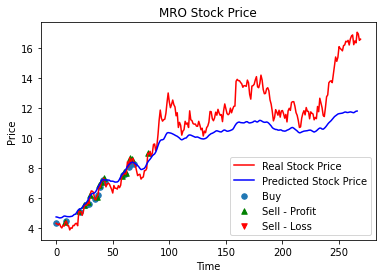

<Figure size 432x288 with 0 Axes>

In [48]:
startDate = datetime.strptime('2020-09-05', "%Y-%m-%d")
endDate = datetime.strptime('2021-11-05', "%Y-%m-%d")
profitC, sharperatioC, sortinoRatioC, calmerRatioC, soldC = company(
    'MRO', startDate=startDate, endDate=endDate, plot=True, s=3)
profitC

In [87]:
eval(startDate='1982-03-01',endDate='2022-02-01',s=3)

100%|██████████| 30/30 [05:53<00:00, 11.78s/it]

Start Date: <built-in method date of datetime.datetime object at 0x7f8216360c00>
End Date: <built-in method date of datetime.datetime object at 0x7f8216360960>
Profit: $4852438842.82
ROI: 970487.77%
Most Profitable Stock: SWKS
Profit for SWKS: $3293334657.99
Least Profitable Stock: FOX
Profit for FOX: $8468.78
Profit S&P500: $20287909.86
S&P500 ROI: 4057.58%
Sharpe Ratio: 3.78
Sortino Ratio: 5.97
Calmer Ratio: 0
Traded 11094 Times


4852438842.82

In [22]:
shifts = {}
for i in companyiesTemp:
    startDate = datetime.strptime('1982-05-01', "%Y-%m-%d")
    endDate = datetime.strptime('2021-12-01', "%Y-%m-%d")
    profitC, shift = optimize(
        i,startDate=startDate,endDate=endDate, plot=False)
    print(i,shift)
    shifts[i] = shift
np.mean(shifts.values)

AAL 9
ABBV 4
ADM 9
AEE 9
AEP 4
AES 18
AKAM 7
AMCR 6
BAC 3
BEN 11
BK 5
BKR 4
BMY 11
BSX 3
BXP 13
CAG 4
CAH 7
CARR 16
CBRE 6
CCL 4
CDNS 17
CDW 7
CF 7
CFG 15
CMA 5
CMS 5
CNP 13
CPB 3
CSCO 6
CSX 5
CTLT 11
DAL 4
DD 4
DISCA 15
DISCK 7
DISH 3
DRE 11
DUK 16
DXC 5
EBAY 8
ED 14
EMN 14
EMR 5
EQR 10
EVRG 5
EXC 10
F 17
FAST 18
FBHS 8
FCX 9
FE 7
FITB 4
FOX 10
FOXA 8
FTV 19
GE 12
GLW 4
GM 9
GPS 3
GRMN 5
HAL 4
HBAN 16
HBI 5
HIG 11
HPE 7
HPQ 12
HST 4
HWM 19
IBM 5
INCY 13
INTC 4
IP 2
IPG 9
IR 6
IRM 11
IVZ 6
JCI 4
JNPR 4
K 3
KEY 5
KIM 5
KMI 17
KO 4
KR 4
L 9
LDOS 4
LEG 5
LKQ 5
LNC 12
LNT 3
LUMN 6
LUV 14
LVS 4
LW 19
LYB 5
LYV 14
MAS 6
MDLZ 5
MET 12
MGM 13
MO 2
MPC 14
MRK 5
MRO 11
MS 3
MSI 3
MU 4
NCLH 9
NEM 4
NI 4
NLOK 5
NLSN 15
NRG 10
NTAP 4
NTRS 11
NWL 6
NWS 16
NWSA 6
PAYX 3
PBCT 11
PEAK 8
PEG 3
PFE 5
PFG 5
PHM 5
PM 12
PNR 9
PNW 5
PPL 5
PRU 6
PSX 4
PWR 4
REG 13
RF 11
RHI 3
SEE 4
STT 5
STX 5
SYF 17
T 2
TAP 4
TER 5
TFC 11
TPR 15
TSN 8
TWTR 5
TXT 4
UA 15
UAA 3
UDR 12
USB 4
VIAC 15
VNO 6
VTR 17
VTRS 19
VZ 2
W

TypeError: unsupported operand type(s) for /: 'builtin_function_or_method' and 'int'

In [26]:
list(shifts.values())

[9,
 4,
 9,
 9,
 4,
 18,
 7,
 6,
 3,
 11,
 5,
 4,
 11,
 3,
 13,
 4,
 7,
 16,
 6,
 4,
 17,
 7,
 7,
 15,
 5,
 5,
 13,
 3,
 6,
 5,
 11,
 4,
 4,
 15,
 7,
 3,
 11,
 16,
 5,
 8,
 14,
 14,
 5,
 10,
 5,
 10,
 17,
 18,
 8,
 9,
 7,
 4,
 10,
 8,
 19,
 12,
 4,
 9,
 3,
 5,
 4,
 16,
 5,
 11,
 7,
 12,
 4,
 19,
 5,
 13,
 4,
 2,
 9,
 6,
 11,
 6,
 4,
 4,
 3,
 5,
 5,
 17,
 4,
 4,
 9,
 4,
 5,
 5,
 12,
 3,
 6,
 14,
 4,
 19,
 5,
 14,
 6,
 5,
 12,
 13,
 2,
 14,
 5,
 11,
 3,
 3,
 4,
 9,
 4,
 4,
 5,
 15,
 10,
 4,
 11,
 6,
 16,
 6,
 3,
 11,
 8,
 3,
 5,
 5,
 5,
 12,
 9,
 5,
 5,
 6,
 4,
 4,
 13,
 11,
 3,
 4,
 5,
 5,
 17,
 2,
 4,
 5,
 11,
 15,
 8,
 5,
 4,
 15,
 3,
 12,
 4,
 15,
 6,
 17,
 19,
 2,
 5,
 13,
 15,
 9,
 15,
 6,
 6,
 17,
 4,
 6]

In [28]:
np.mean(list(shifts.values()))


8.102409638554217